# DATA PREPROCESSING


In [1]:
import pandas as pd
import numpy as np 
import os 
import sys 
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn 

In [ ]:
# LOAD THE NASA DATASET
# The NASA dataset is available at: https://data.nasa.gov/dataset/Commercial-Jet-Engine-Failure-Prediction-Data-Set/2g7c-4j8h
df001_train = pd.read_csv(r'C:\Users\elroy\OneDrive\Desktop\JetEngineFailureClassification\train_FD001.txt', sep='\s+', header=None)
df001_test = pd.read_csv(r'C:\Users\elroy\OneDrive\Desktop\JetEngineFailureClassification\test_FD001.txt', sep='\s+', header=None)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\elroy\AppData\Local\Temp\ipykernel_27688\2065538069.py:1: SyntaxWarning: invalid escape sequence '\s'
  df001_train = pd.read_csv(r'C:\Users\elroy\OneDrive\Desktop\JetEngineFailureClassification\train_FD001.txt', sep='\s+', header=None)
C:\Users\elroy\AppData\Local\Temp\ipykernel_27688\2065538069.py:2: SyntaxWarning: invalid escape sequence '\s'
  df001_test = pd.read_csv(r'C:\Users\elroy\OneDrive\Desktop\JetEngineFailureClassification\test_FD001.txt', sep='\s+', header=None)


In [74]:
df001_rul_test = pd.read_csv(r'RUL_FD001.txt', sep='\s+', header=None)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\elroy\AppData\Local\Temp\ipykernel_27688\1468073210.py:1: SyntaxWarning: invalid escape sequence '\s'
  df001_rul_test = pd.read_csv(r'RUL_FD001.txt', sep='\s+', header=None)


In [75]:
df001_rul_test

,0
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


In [3]:
columns = ['engine_id', 'cycle', 
           'altitude', 'mach_number', 'sea_level_temp', 
           'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 
           'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRe', 
           'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']
df001_train.columns = columns
df001_test.columns = columns
# Each engine has a different lifetime 
# so we find the maximum cycle of each engine separately 
# then at each cycle subtract to know how much life is left
# 1. Calculate max engine cycle for each engine: 
max_cycle_fd001 = df001_train.groupby('engine_id')['cycle'].max()

# 2. Merge max cycle info back into the Dataset: 
df001_train = df001_train.merge(max_cycle_fd001.to_frame('max_cycle'), on='engine_id', how='left')

# 3. Calculate RUL (Remaining useful cycles: Max cycle - cycle)
df001_train['RUL'] = df001_train['max_cycle'] - df001_train['cycle']
df001_train.drop('max_cycle', axis=1, inplace=True)


In [6]:
# Check and Remove constant value columns from df001_train 
def drop_constant_value(dataframe):
    '''
    Function:
        - Deletes constant value columns in the data set.
        - A constant value is a value that is the same for all data in the data set.
        - A value is considered constant if the minimum (min) and maximum (max) values in the column are the same.
    Args:
        dataframe -> dataset to validate
    Returned value:
        dataframe -> dataset cleared of constant values
    '''

    # Creating a temporary variable to store a column name with a constant value
    constant_column = []

    # The process of finding a constant value by looking at the minimum and maximum values
    for col in dataframe.columns:
        min = dataframe[col].min()
        max = dataframe[col].max()

        # Append the column name if the min and max values are equal.
        if min == max:
            constant_column.append(col)

    # Delete column with constant value
    dataframe.drop(columns=constant_column, inplace=True)

    # return data
    return dataframe

# call function to drop constant value        
df001_train = drop_constant_value(df001_train)


In [97]:
df001_test = drop_constant_value(df001_test)

# VISUALIZATION + ANALYSIS

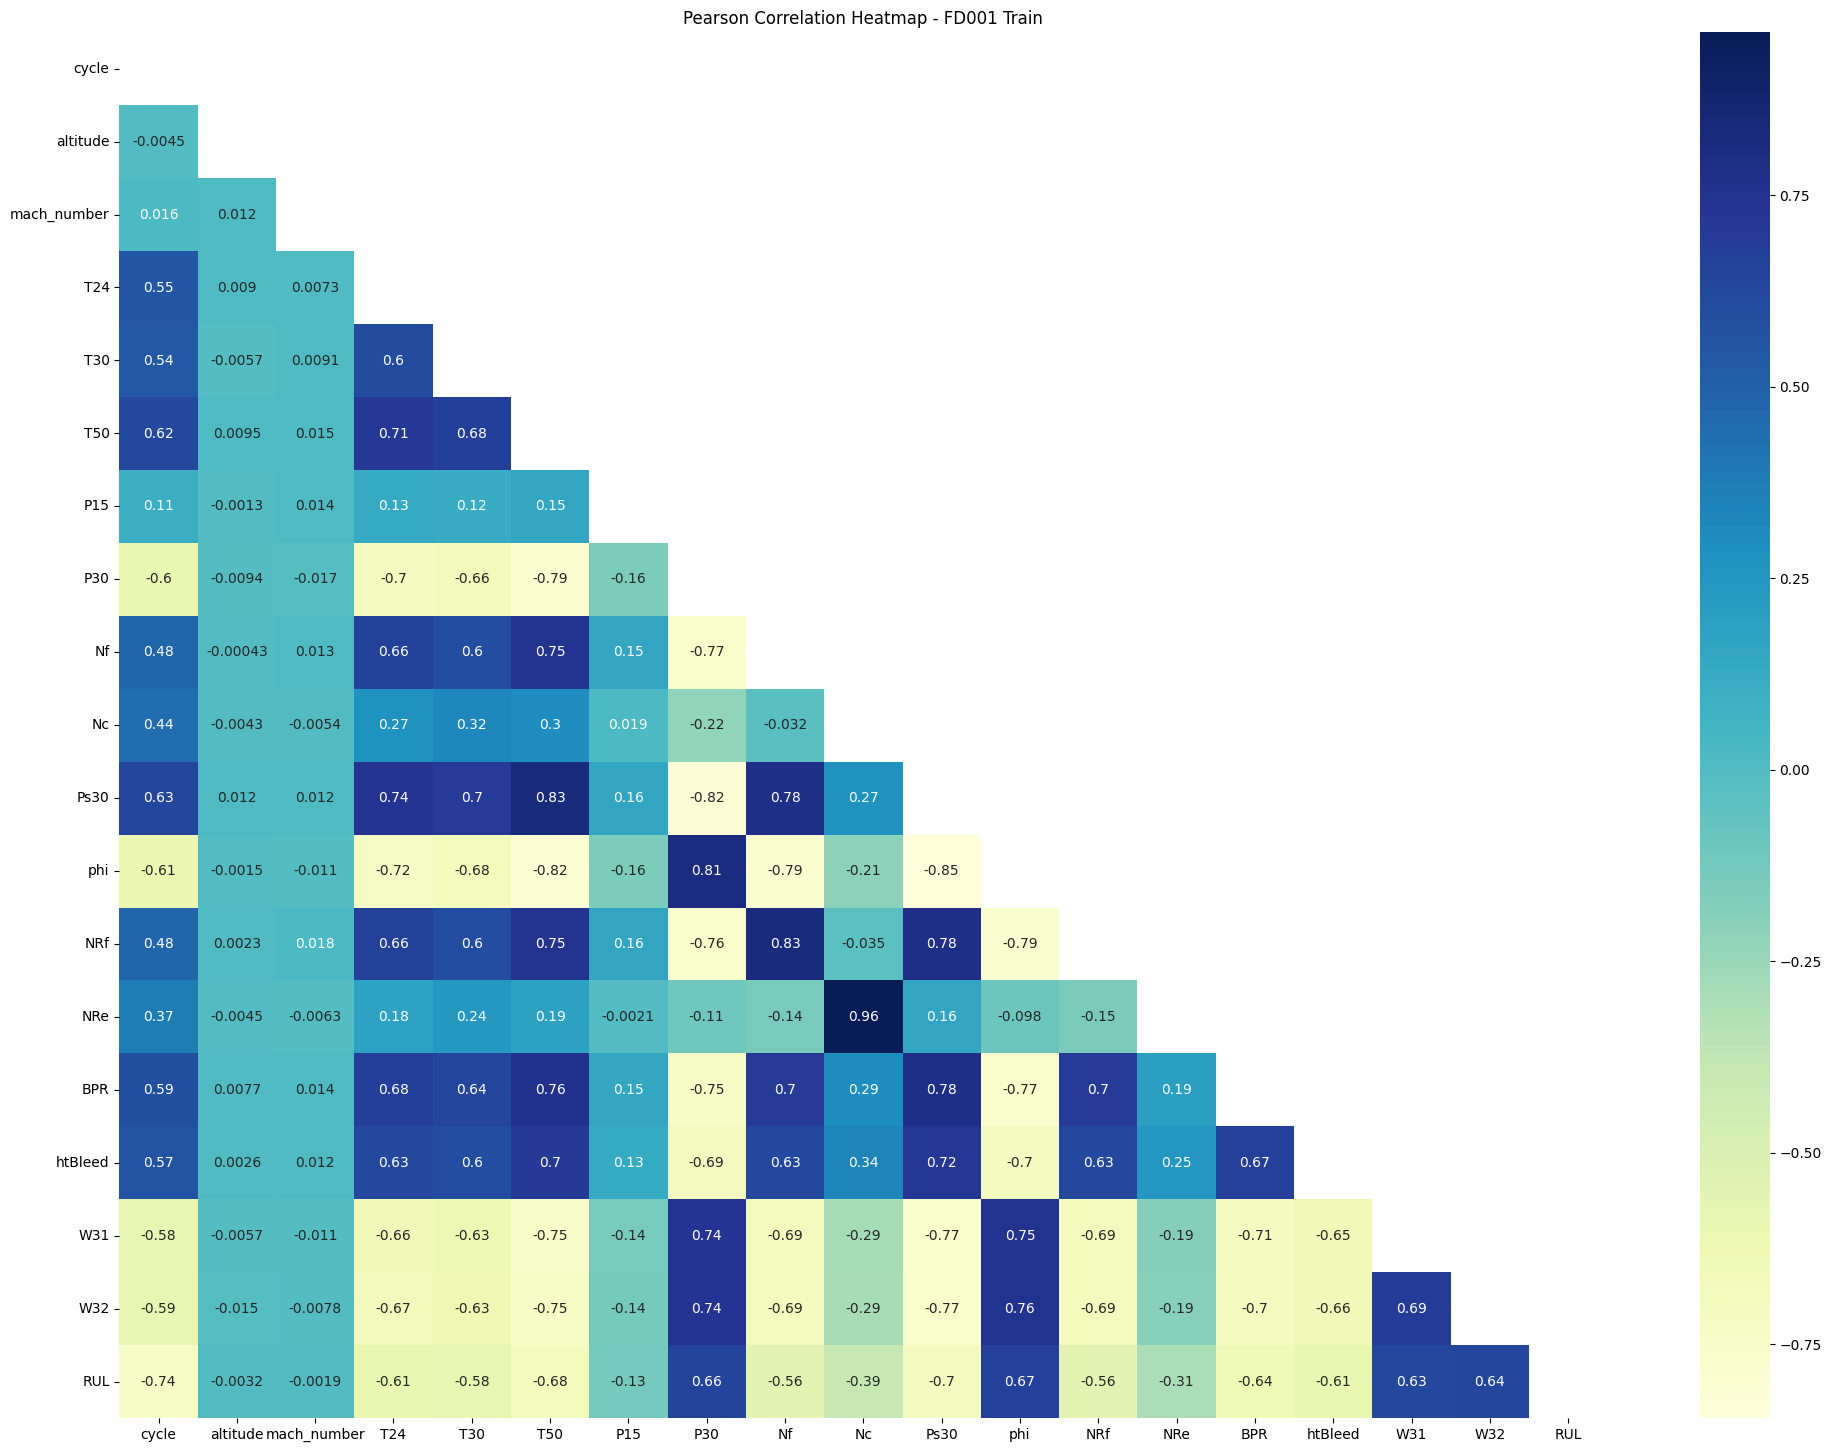

In [ ]:
# Corr distance plot (Left inner triangle) with target variable (RUL)
feature_cols_fd001 = df001_train.columns.drop(['engine_id'])
corr_fd001 = df001_train[feature_cols_fd001].corr(method='pearson') 
# Plot the correlation matrix 
plt.figure(figsize=(24,18)) 
sns.heatmap(corr_fd001, cmap='YlGnBu', annot= True, mask = np.triu(corr_fd001.corr(method='pearson')))
plt.title('Pearson Correlation Heatmap - FD001 Train') 
plt.show()




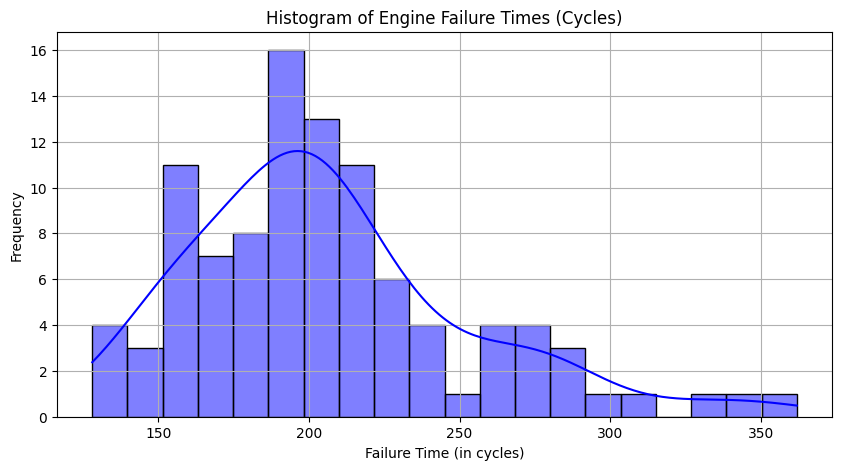

In [19]:
# Weilbull distribution plot 
# Weibull distribution is used to model the time until a failure occurs. 
from scipy.stats import weibull_min 
# First we need to analyze time to failure (TTF)
failure_times = df001_train.groupby('engine_id')['cycle'].max().values
plt.figure(figsize=(10, 5))
sns.histplot(failure_times, bins=20, kde=True, color='blue')
plt.title("Histogram of Engine Failure Times (Cycles)")
plt.xlabel("Failure Time (in cycles)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

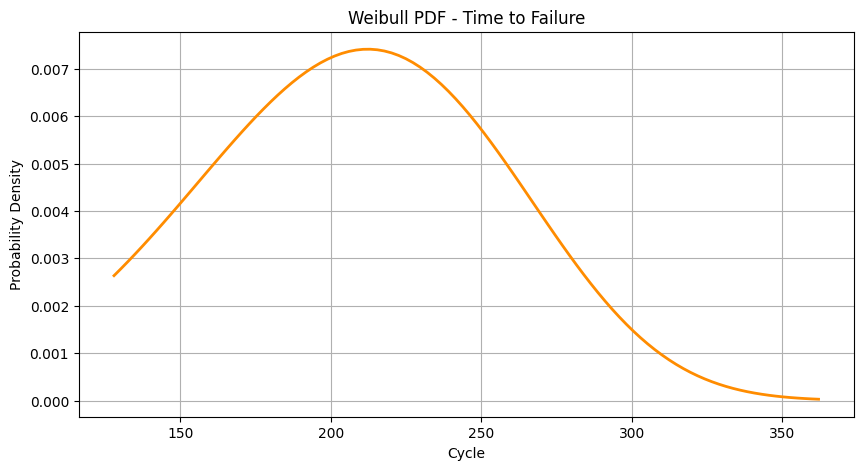

In [ ]:
# FITTING THE WEIBULL DISTRIBUTION
from scipy.stats import weibull_min
""" Shape parameter (β): Determines the failure rate behavior.

β < 1 → early failures (infant mortality)

β = 1 → random failures (constant failure rate)

β > 1 → wear-out failures (increasing failure rate)

β = 2 → exponential distribution (constant failure rate) """
# Fit the Weibull distribution
shape, loc, scale = weibull_min.fit(failure_times, floc=0)
# PROBABILTIES OF FAILURE
x = np.linspace(min(failure_times), max(failure_times), 100)
pdf = weibull_min.pdf(x, shape, loc=0, scale=scale)
plt.figure(figsize=(10, 5))
plt.plot(x, pdf, color='darkorange', lw=2)
plt.title("Weibull PDF - Time to Failure")
plt.xlabel("Cycle")
plt.ylabel("Probability Density")
plt.grid(True)
plt.show()


# Probability of failure is higher at cycles 200 and 220 
# and lower at cycles 300 and 350. 

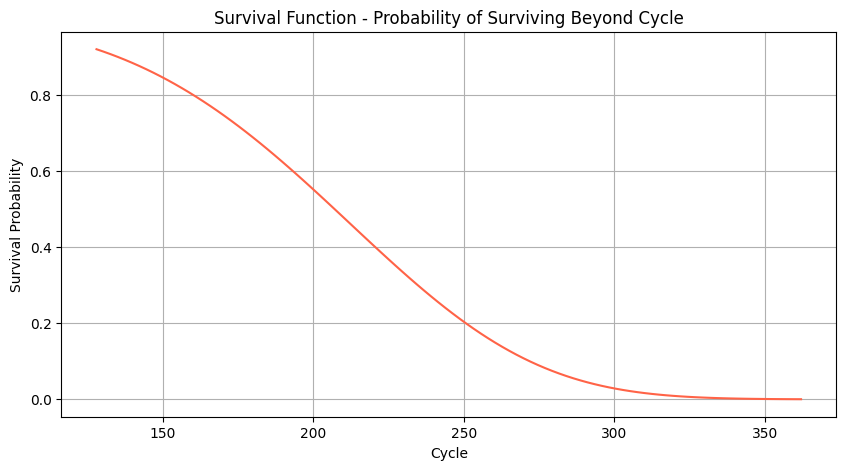

In [ ]:
# SURVIVAL FUNCTION 
cdf = weibull_min.cdf(x, shape, loc=loc, scale=scale)
survival = 1 - cdf
plt.figure(figsize=(10, 5))
plt.plot(x, survival, color='tomato')
plt.title('Survival Function - Probability of Surviving Beyond Cycle')
plt.xlabel('Cycle')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()
# Survival function is used to estimate the probability of an engine surviving beyond a certain cycle.
# We can clearly see that the survival probability decreases as the cycle increases. 


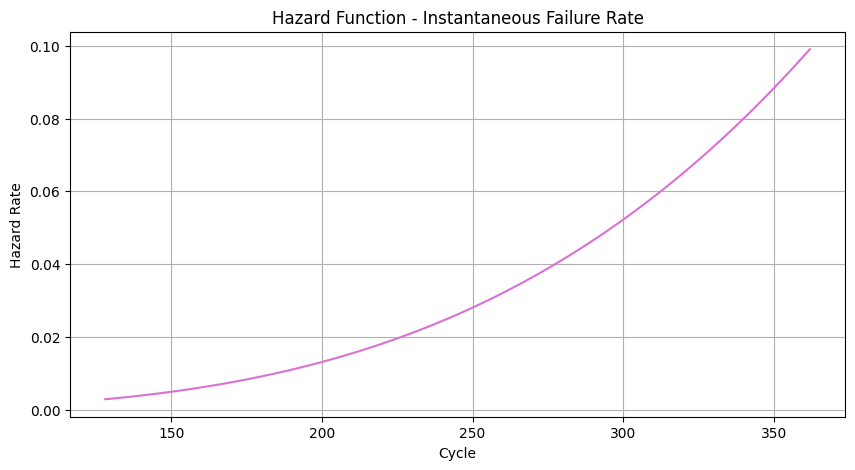

In [ ]:
# Plotting the Hazard curve
pdf = weibull_min.pdf(x, shape, loc=loc, scale=scale)
hazard = pdf / survival
plt.figure(figsize=(10, 5))
plt.plot(x, hazard, color='orchid')
plt.title('Hazard Function - Instantaneous Failure Rate')
plt.xlabel('Cycle')
plt.ylabel('Hazard Rate')
plt.grid(True)
plt.show()
# Hazard function is used to estimate the instantaneous failure rate at a given time (cycle).
# We can observe that hazard rate increases as the cycle increases, indicating that the risk of failure is higher at later cycles.


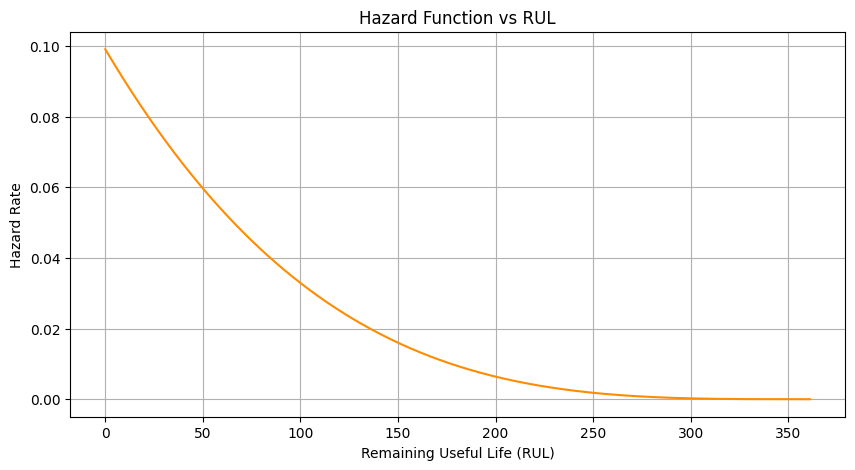

In [24]:
# We can create Hazard variable in the dataset using the hazard curve/weibull distribution 
# Create 3 Risk Classes Based on Hazard Rate and RUL
x = np.linspace(1, np.max(failure_times), 500)  # cycles
rul = np.max(failure_times) - x               # compute RUL

shape, loc, scale = weibull_min.fit(failure_times, floc=0)
pdf = weibull_min.pdf(x, shape, loc=loc, scale=scale)
cdf = weibull_min.cdf(x, shape, loc=loc, scale=scale)
survival = 1 - cdf
hazard = pdf / survival
plt.figure(figsize=(10, 5))
plt.plot(rul, hazard, color='darkorange')
plt.title('Hazard Function vs RUL')
plt.xlabel('Remaining Useful Life (RUL)')
plt.ylabel('Hazard Rate')
plt.grid(True)
plt.show()



In [ ]:
# Quantile based BINNING FOR CLASSIFICATION 
# Create bins for RUL values 
df001_train['RUL'].describe()

""" 4-Class Approach:
Class 0 (High Hazard Risk): RUL < 50

These engines are very close to failure
Class 1 (Warning): 50 ≤ RUL < 100

These engines are approaching failure but haven’t reached the point of high risk yet.(Warning stage)

Class 2 (Moderately Healthy): 100 ≤ RUL < 155

These engines are in the mid-life stage and still have some useful life left. 
The risk of failure is lower compared to the earlier stages.

Class 3 (Healthy): RUL ≥ 155

These engines are in good health, with a significant amount of useful life left. 
The hazard rate here is the lowest.


"""

def assign_rul_class(rul):
    if rul < 50:
        return 3  # High hazard risk
    elif 50 <= rul < 100:
        return 2  # Warning
    elif 100 <= rul < 155:
        return 1  # Moderately healthy
    else:
        return 0  # Healthy
    

# Apply the function to create a new RUL_Class column
df001_train['Health_Index'] = df001_train['RUL'].apply(assign_rul_class)


In [29]:
df001_train['Health_Index'].value_counts()

Health_Index
1    5392
0    5239
2    5000
3    5000
Name: count, dtype: int64

<Axes: xlabel='Health_Index'>

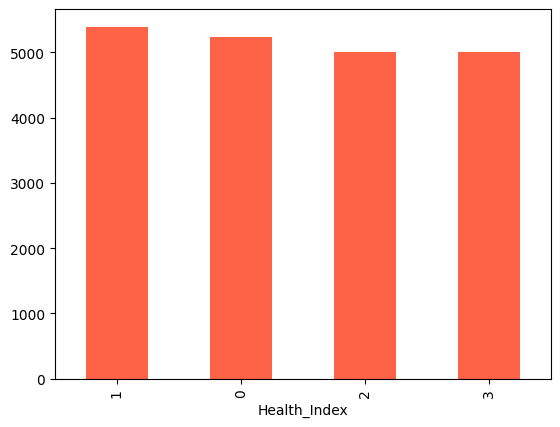

In [33]:
df001_train['Health_Index'].value_counts().plot(kind='bar', color='tomato')

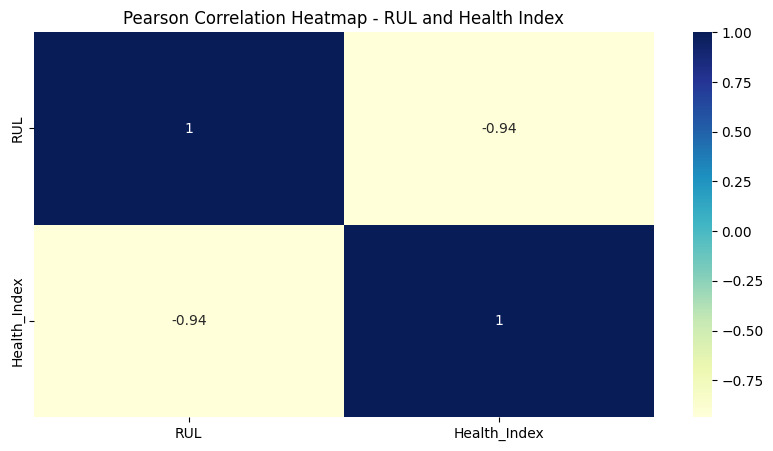

In [35]:
# Correlation between RUL and Health Index 
plt.figure(figsize=(10, 5)) 
corr_fd001 = df001_train[['RUL', 'Health_Index']].corr(method='pearson')
sns.heatmap(corr_fd001, cmap='YlGnBu', annot=True)
plt.title('Pearson Correlation Heatmap - RUL and Health Index')
plt.show()

C:\Users\elroy\AppData\Local\Temp\ipykernel_27688\2365624379.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=health_index_corr.values, y=health_index_corr.index, palette='viridis')


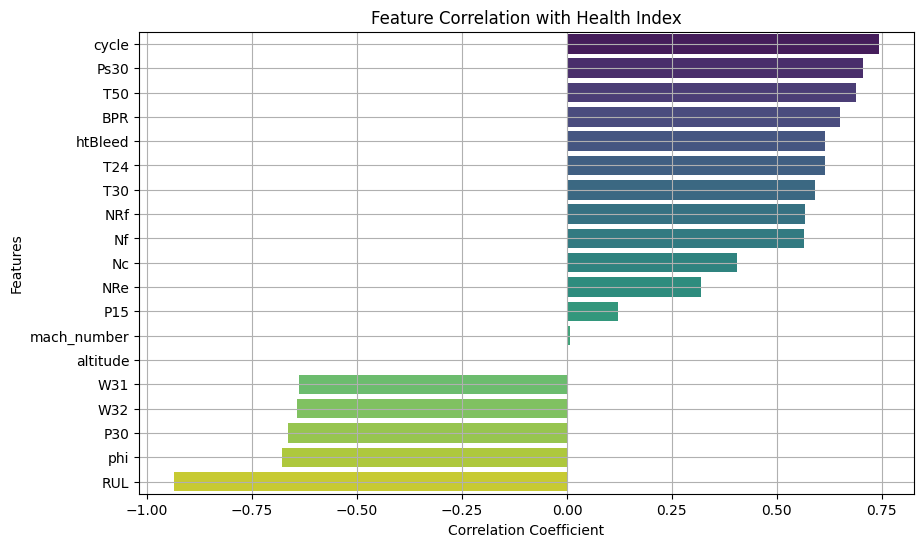

In [44]:
# Calculate correlation of each feature with the Health Index
health_index_corr = df001_train[feature_cols_fd001].corrwith(df001_train['Health_Index'])
health_index_corr = health_index_corr.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=health_index_corr.values, y=health_index_corr.index, palette='viridis')
plt.title('Feature Correlation with Health Index')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(True)
plt.show()


C:\Users\elroy\AppData\Local\Temp\ipykernel_27688\185704132.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rul_corr.values, y=rul_corr.index, palette='viridis')


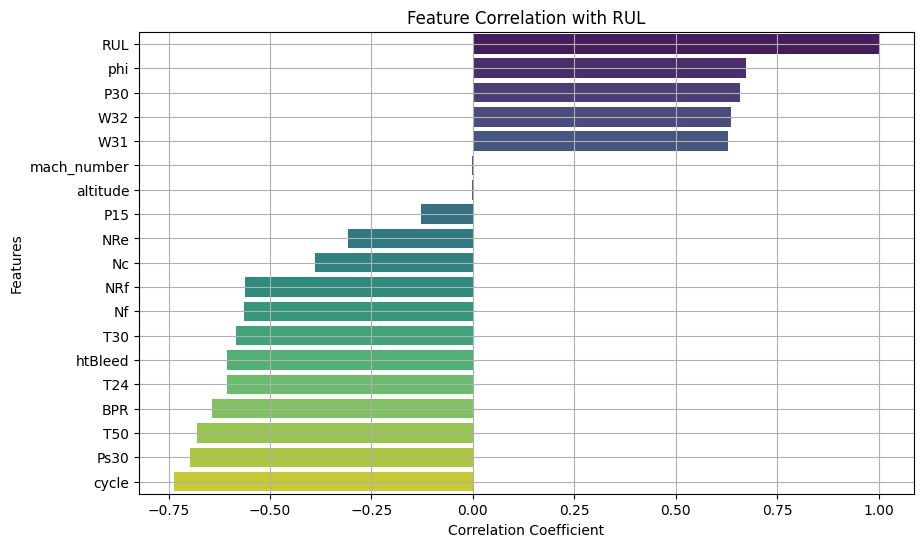

In [45]:
# same thing for RUL
rul_corr = df001_train[feature_cols_fd001].corrwith(df001_train['RUL'])
rul_corr = rul_corr.sort_values(ascending=False)
plt.figure(figsize=(10, 6)) 
sns.barplot(x=rul_corr.values, y=rul_corr.index, palette='viridis')
plt.title('Feature Correlation with RUL')
plt.xlabel('Correlation Coefficient') 
plt.ylabel('Features') 
plt.grid(True) 
plt.show()




# FEATURE ENGINEERING



In [ ]:
# FEATURE ENGINEERING 
# Remove mach_number, altitude, P15,NRe,NC columns they have less than 0.5 corr. with RUL and Health index 
df001_train.drop(['mach_number', 'altitude', 'P15', 'NRe', 'Nc'], axis=1, inplace=True) 
df001_test.drop(['mach_number', 'altitude', 'P15', 'NRe', 'Nc'], axis=1, inplace=True) 
df001_train


In [51]:
df001_train.columns.tolist()

['engine_id',
 'cycle',
 'T24',
 'T30',
 'T50',
 'P30',
 'Nf',
 'Ps30',
 'phi',
 'NRf',
 'BPR',
 'htBleed',
 'W31',
 'W32',
 'RUL',
 'Health_Index']

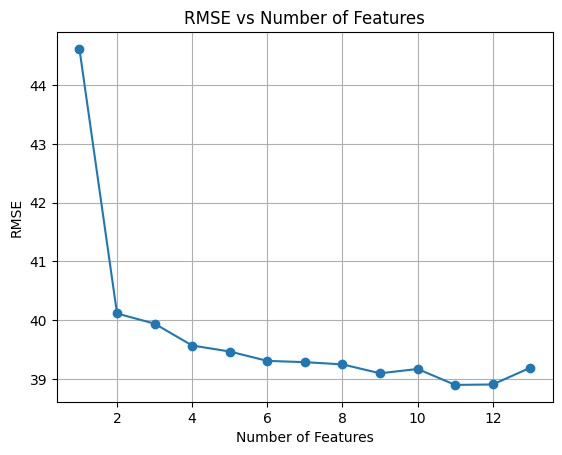

['cycle', 'T50', 'P30', 'Nf', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32']


In [ ]:
# RFE + XGBoost for Feature Selection
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, KFold
X = df001_train.drop(columns=['engine_id', 'Health_Index', 'RUL'])
y = df001_train['RUL']

model = XGBRegressor(random_state=42)
rmse_list = []
feature_counts = list(range(1, X.shape[1] + 1))

for n in feature_counts:
    rfe = RFE(model, n_features_to_select=n)
    X_rfe = rfe.fit_transform(X, y)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse = -1 * cross_val_score(model, X_rfe, y, cv=cv, scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse)

plt.plot(feature_counts, rmse_list, marker='o') # Plot RMSE vs Number of Features
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Features')
plt.grid(True)
plt.show()

rfe = RFE(model, n_features_to_select=rmse_list.index(min(rmse_list)) + 1)
rfe.fit(X, y)
selected_features = X.columns[rfe.support_]
print(selected_features.tolist())




In [53]:
rmse_list

[44.61453458721562,
 40.11370633649709,
 39.940128922669835,
 39.56845227342889,
 39.46659417529892,
 39.30706768782104,
 39.28564049969388,
 39.247424496176315,
 39.09600052326696,
 39.1694816163252,
 38.89806754193914,
 38.906051617216846,
 39.190953511205606]

In [ ]:
# include only the selected features in the dataset
features = ['cycle', 'T50', 'P30', 'Nf', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32']
df001_train = df001_train[['engine_id', 'Health_Index', 'RUL'] + features]
df001_test = df001_test[['engine_id'] + features]
df001_train.head(20)

In [ ]:
# Prepare the data for training and holdout
# 75% for training and 25% for holdout 
from sklearn.model_selection import train_test_split 
X = df001_train.drop(columns=['engine_id', 'Health_Index', 'RUL']) 
y = df001_train['RUL'] 
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.25, random_state=42) 

In [59]:
X_train.shape, y_train.shape, X_holdout.shape, y_holdout.shape

((15473, 11), (15473,), (5158, 11), (5158,))

In [70]:
# TRAINING THE MODEL (REGRESSION)
# STACKED ENSEMBLE REGRESSION (Meta as Linear Regression)
from sklearn.ensemble import StackingRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

estimators = [
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('svr', make_pipeline(StandardScaler(), SVR())),
    ('knn', make_pipeline(StandardScaler(), KNeighborsRegressor()))
]



stack1 = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
scores = cross_val_score(stack1, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print(-scores)
print('Average RMSE of Stacking model 1:', -np.mean(scores))



[36.77520858 37.77090407 37.25388776 37.81408084 37.47410282]
Average RMSE of Stacking model 1: 37.41763681448676


In [69]:
# TEST StACKING MODEL 1 on HOLDOUT 
from sklearn.metrics import root_mean_squared_error
stack1.fit(X_train, y_train) 
y_pred = stack1.predict(X_holdout) 

RMSE of Stacking model 1 on holdout: 36.57043550292948


c:\Users\elroy\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


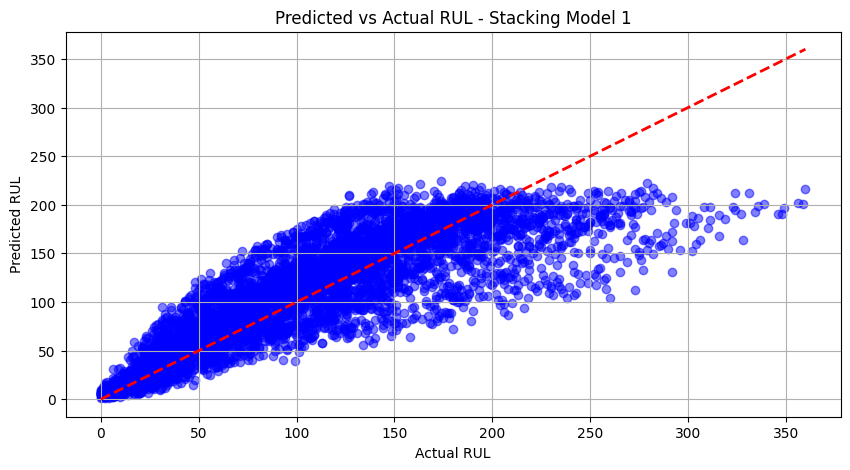

In [71]:
rmse = mean_squared_error(y_holdout, y_pred, squared=False) 
print('RMSE of Stacking model 1 on holdout:', rmse) 
# Plotting the predicted vs actual values 
plt.figure(figsize=(10, 5))
plt.scatter(y_holdout, y_pred, color='blue', alpha=0.5)
plt.plot([y_holdout.min(), y_holdout.max()], [y_holdout.min(), y_holdout.max()], 'r--', lw=2)
plt.title('Predicted vs Actual RUL - Stacking Model 1')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL') 
plt.grid(True) 
plt.show()

In [72]:
# Stacking Ensemble with MLP as final estimator
from sklearn.neural_network import MLPRegressor
estimators = [
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('svr', SVR()),
    ('knn', KNeighborsRegressor())
]

# Create stacking regressor with MLP as final estimator
stack2 = StackingRegressor(
    estimators=estimators,
    final_estimator=MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
)

# Cross-validation on the stacking model
scores2 = cross_val_score(stack2, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

# Print RMSE scores
print(-scores2)
print('Average RMSE of Stacking model with MLP as final estimator:', -np.mean(scores))


[37.02677367 37.93561177 37.28906496 37.76439162 37.48025047]
Average RMSE of Stacking model with MLP as final estimator: 37.41763681448676


c:\Users\elroy\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE of Stacking model 2 on holdout: 36.636724825144604


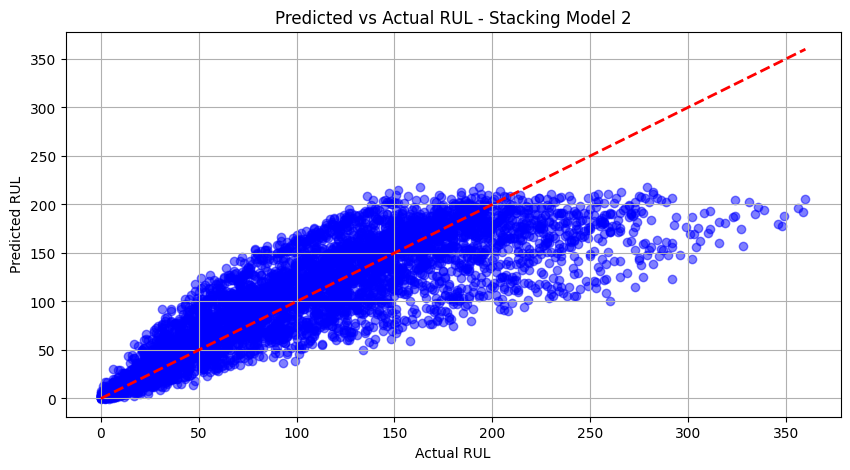

In [73]:
# TEST StACKING MODEL 2 on HOLDOUT 
from sklearn.metrics import root_mean_squared_error
stack2.fit(X_train, y_train) 
y_pred2 = stack2.predict(X_holdout) 
rmse2 = mean_squared_error(y_holdout, y_pred2, squared=False) 
print('RMSE of Stacking model 2 on holdout:', rmse2) 
# Plotting the predicted vs actual values 
plt.figure(figsize=(10, 5))
plt.scatter(y_holdout, y_pred2, color='blue', alpha=0.5)
plt.plot([y_holdout.min(), y_holdout.max()], [y_holdout.min(), y_holdout.max()], 'r--', lw=2)
plt.title('Predicted vs Actual RUL - Stacking Model 2')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL') 
plt.grid(True) 
plt.show()

In [78]:
# Now we test it on df001_test 
# Preprocess the test data in the same way as the training data 
# True RUL for test data was already given 
df001_test

,engine_id,cycle,T50,P30,Nf,Ps30,phi,NRf,BPR,htBleed,W31,W32
0,1,1,1398.21,553.90,2388.04,47.20,521.72,2388.03,8.4052,392,38.86,23.3735
1,1,2,1395.42,554.85,2388.01,47.50,522.16,2388.06,8.3803,393,39.02,23.3916
2,1,3,1401.34,554.11,2388.05,47.50,521.97,2388.03,8.4441,393,39.08,23.4166
3,1,4,1406.42,554.07,2388.03,47.28,521.38,2388.05,8.3917,391,39.00,23.3737
4,1,5,1401.92,554.16,2388.01,47.31,522.15,2388.03,8.4031,390,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,1415.79,553.41,2388.02,47.69,520.69,2388.00,8.4715,394,38.65,23.1974
13092,100,195,1422.05,553.22,2388.05,47.60,521.05,2388.09,8.4512,395,38.57,23.2771
13093,100,196,1406.82,553.04,2388.11,47.57,521.18,2388.04,8.4569,395,38.62,23.2051
13094,100,197,1419.36,553.37,2388.07,47.61,521.33,2388.08,8.4711,395,38.66,23.2699


In [ ]:
# TEST StACKING MODEL 1 on NASA Test data provided earlier 
from sklearn.metrics import root_mean_squared_error
stack1.fit(X_train,y_train)

In [ ]:
# Last cycle of the engine
df001_test_last = df001_test.groupby('engine_id').last()
df001_test_last


RMSE of Stacking model 1 on training: 28.196149035384792


c:\Users\elroy\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


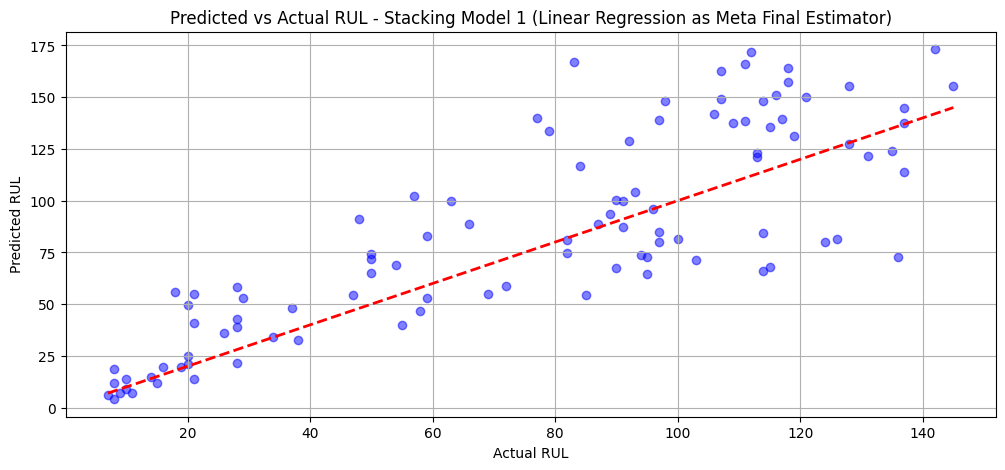

In [113]:
# TEST StACKING MODEL 1 on NASA REAL DATA TEST SET
y_pred3 = stack1.predict(df001_test_last) 
rmse3 = mean_squared_error(df001_rul_test, y_pred3, squared=False) 
print('RMSE of Stacking model 1 on training:', rmse3) 
# Plotting the predicted vs actual values 
plt.figure(figsize=(12, 5))
plt.scatter(df001_rul_test, y_pred3, color='blue', alpha=0.5)
plt.plot([df001_rul_test.min(), df001_rul_test.max()], [df001_rul_test.min(), df001_rul_test.max()], 'r--', lw=2)
plt.title('Predicted vs Actual RUL - Stacking Model 1 (Linear Regression as Meta Final Estimator)')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL') 
plt.grid(True) 
plt.show()

RMSE of Stacking model 2 on training: 26.61214618882026


c:\Users\elroy\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


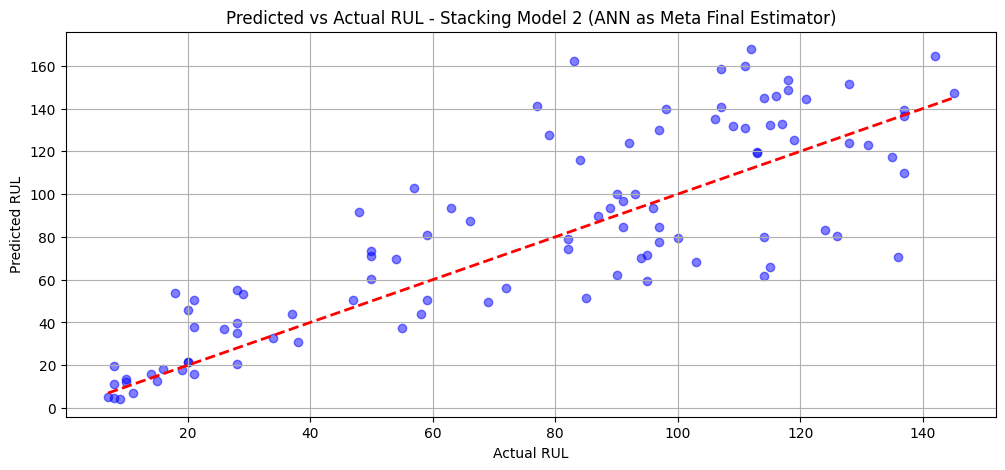

In [110]:
# Now do the same for stack2 (model2)
# TEST StACKING MODEL 2 on NASA REAL DATA TEST SET
y_pred4 = stack2.predict(df001_test_last) 
rmse4 = mean_squared_error(df001_rul_test, y_pred4, squared=False) 
print('RMSE of Stacking model 2 on training:', rmse4) 
# Plotting the predicted vs actual values 
plt.figure(figsize=(12, 5))
plt.scatter(df001_rul_test, y_pred4, color='blue', alpha=0.5)
plt.plot([df001_rul_test.min(), df001_rul_test.max()], [df001_rul_test.min(), df001_rul_test.max()], 'r--', lw=2)
plt.title('Predicted vs Actual RUL - Stacking Model 2 (ANN as Meta Final Estimator)')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL') 
plt.grid(True) 
plt.show()

In [ ]:
# Save the model to disk 
# generate dowloadable file 
import joblib 
joblib.dump(stack1, 'stacking_model1.pkl')
joblib.dump(stack2, 'stacking_model2.pkl') 
from IPython.display import FileLink 
FileLink('stacking_model1.pkl')  # Stack 1 with Linear Regression as final estimator 
FileLink('stacking_model2.pkl')   # Stack 2 with ANN as final estimator

c:\Users\elroy\OneDrive\Desktop\JetEngineFailureClassification\stacking_model2.pkl

In [119]:
FileLink('stacking_model1.pkl') 

c:\Users\elroy\OneDrive\Desktop\JetEngineFailureClassification\stacking_model1.pkl

In [122]:
df001_train.to_csv('classification.csv', index=False)